# **Dependencias**

In [ ]:
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /tmp/pip-req-build-ttwlipje
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /tmp/pip-req-build-ttwlipje
  Resolved https://github.com/pycaret/pycaret.git to commit 58ec3c282d58e94727f9d5b77b49f241e9103ab3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.regression import *
from pycaret.classification import *

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, KFold
)

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

sns.set_theme()
RND = 42

# **Importação do Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wardabilal/spotify-global-music-dataset-20092025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'spotify-global-music-dataset-20092025' dataset.
Path to dataset files: /kaggle/input/spotify-global-music-dataset-20092025


# **Análise Exploratória de Dados (EDA) e Pré-processamento**
Esta etapa focou na compreensão do conjunto de dados, que contém características de faixas musicais, incluindo dados do artista e do álbum (ex: artist_popularity, track_duration_ms, album_total_tracks, explicit, album_year).

**Limpeza de Dados e Variáveis**

Foram inspecionadas as estatísticas descritivas para identificar valores nulos ou inconsistentes.

As variáveis categóricas foram tratadas antes da modelagem.

A coluna explicit é um exemplo de variável binária que foi utilizada para o problema de Classificação.

In [ ]:
df = pd.read_csv("/kaggle/input/spotify-global-music-dataset-20092025/track_data_final.csv")
df.head(5)

,track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
0,6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,17755451.0,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
1,2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734.0,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
2,1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,145396321.0,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
3,7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,118692183.0,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
4,0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,68997177.0,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8778 non-null   object 
 1   track_name          8776 non-null   object 
 2   track_number        8778 non-null   int64  
 3   track_popularity    8778 non-null   int64  
 4   track_duration_ms   8778 non-null   int64  
 5   explicit            8778 non-null   bool   
 6   artist_name         8774 non-null   object 
 7   artist_popularity   8774 non-null   float64
 8   artist_followers    8774 non-null   float64
 9   artist_genres       8774 non-null   object 
 10  album_id            8778 non-null   object 
 11  album_name          8776 non-null   object 
 12  album_release_date  8778 non-null   object 
 13  album_total_tracks  8778 non-null   int64  
 14  album_type          8778 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(8)
memory usag

In [ ]:
df = df.drop(columns=["track_id", "album_id"])

In [ ]:
df["explicit"] = df["explicit"].astype(int)

In [ ]:
df["album_release_date"] = pd.to_datetime(df["album_release_date"], errors="coerce")
df["album_year"] = df["album_release_date"].dt.year

In [ ]:
df = df.dropna(subset=["artist_popularity", "artist_followers", "artist_genres", "album_year"])

In [ ]:
df.head(5)

,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_name,album_release_date,album_total_tracks,album_type,album_year
0,3,57,61,213173,0,Britney Spears,80.0,17755451.0,['pop'],The Singles Collection,2009-11-09,58,compilation,2009.0
1,Clouds,1,67,158760,0,BUNT.,69.0,293734.0,['stutter house'],Clouds,2023-01-13,1,single,2023.0
2,Forever & Always (Taylor’s Version),11,63,225328,0,Taylor Swift,100.0,145396321.0,[],Fearless (Taylor's Version),2021-04-09,26,album,2021.0
3,I Didn't Change My Number,2,72,158463,1,Billie Eilish,90.0,118692183.0,[],Happier Than Ever,2021-07-30,16,album,2021.0
4,Man Down,7,57,267013,0,Rihanna,90.0,68997177.0,[],Loud,2010-01-01,13,album,2010.0


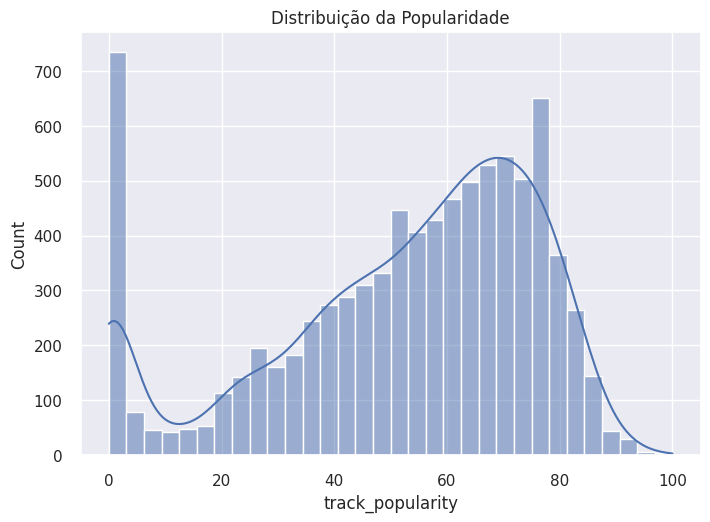

In [ ]:
sns.histplot(df["track_popularity"], kde=True)
plt.title("Distribuição da Popularidade")
plt.show()

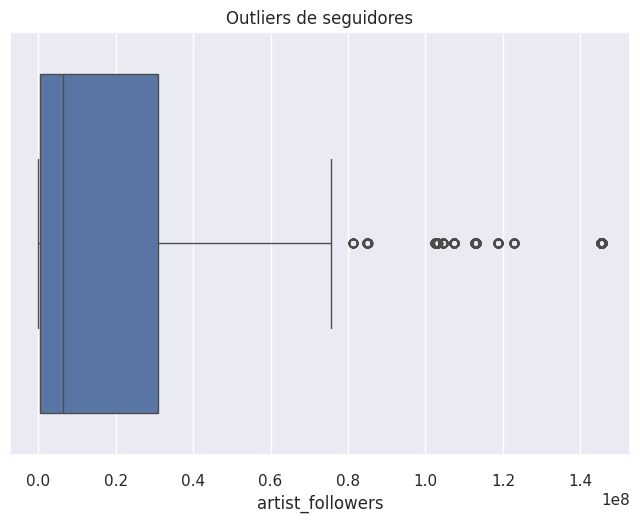

In [ ]:
sns.boxplot(x=df["artist_followers"])
plt.title("Outliers de seguidores")
plt.show()

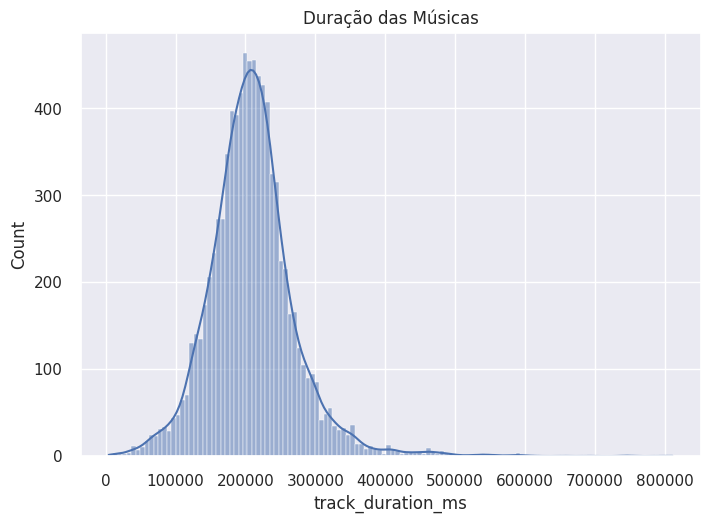

In [ ]:
sns.histplot(df["track_duration_ms"], kde=True)
plt.title("Duração das Músicas")
plt.show()

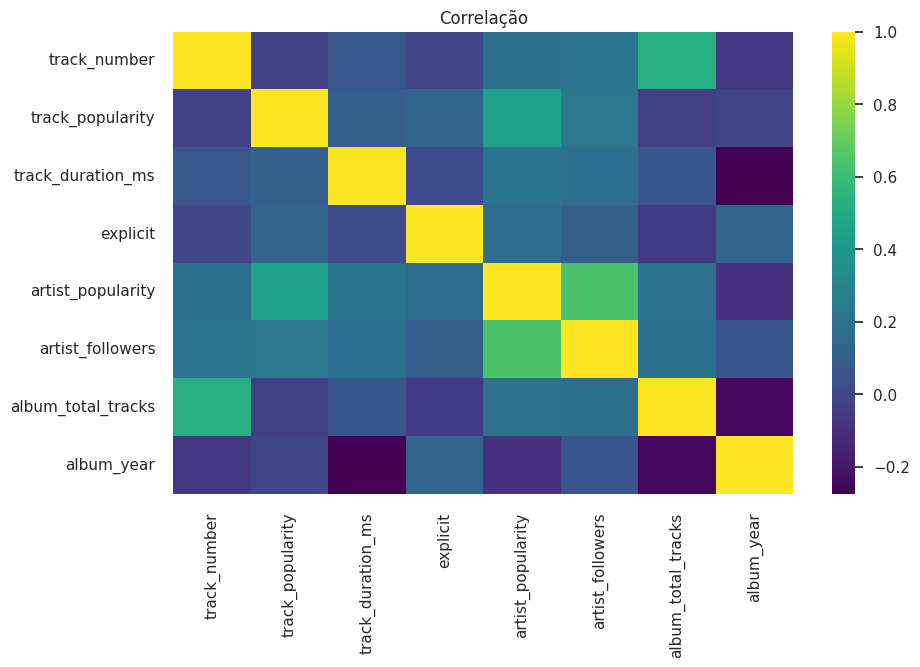

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="viridis", annot=False)
plt.title("Correlação")
plt.show()

In [ ]:
df["hit"] = (df["track_popularity"] >= 70).astype(int)
df["hit"].value_counts()

,count
hit,
0,6190
1,2383


# **Implementação e Resultados Iniciais (Statsmodels)**
Para a Regressão Múltipla, o modelo OLS (Mínimos Quadrados Ordinários) foi implementado usando a biblioteca statsmodels para fornecer uma visão estatística detalhada do relacionamento entre as variáveis preditoras e a variável-alvo contínua.

**Análise dos Coeficientes do OLS**

O R² Ajustado do modelo foi de 0.164, indicando que aproximadamente 16.4% da variância na variável-alvo (popularidade da faixa) é explicada pelas variáveis independentes.

Os coeficientes estatisticamente significantes (p-valor < 0.05) indicam as seguintes relações:

**artist_popularity:** Coeficiente positivo (+0.6586). Isso sugere que, à medida que a popularidade do artista aumenta, a variável-alvo (ex: a popularidade da faixa) também aumenta.

**track_duration_ms:** Coeficiente positivo (+7.729e-06). Músicas mais longas estão associadas a um leve aumento na variável-alvo.

**album_total_tracks:** Coeficiente negativo (-0.2315). Faixas que pertencem a álbuns com mais músicas tendem a ter um valor menor na variável-alvo, o que pode indicar que em álbuns maiores, a atenção se dispersa.

**explicit:** Coeficiente positivo (+2.1723). Faixas com conteúdo explícito tendem a ter um valor mais alto na variável-alvo.

Variável Não Significativa: A variável album_year teve um p-valor alto (0.600), indicando que não há evidência estatística de que o ano do álbum, por si só, tenha um impacto significativo no alvo quando as outras variáveis estão no modelo.

**Diagnóstico dos Resíduos**

A análise dos resíduos revelou dois pontos importantes para a limitação do modelo OLS:

**Normalidade:** O teste de Shapiro-Wilk confirmou que os resíduos NÃO seguem uma distribuição normal (p < 0.05). Isso viola uma das premissas chave da Regressão Linear.

**Multicolinearidade:** O Condition Number grande (1.08e+10) no resumo do OLS sugere a presença de forte multicolinearidade entre os preditores, o que pode tornar a interpretação dos coeficientes instável.

In [ ]:
features = [
    "artist_popularity",
    "artist_followers",
    "track_duration_ms",
    "track_number",
    "album_total_tracks",
    "explicit",
    "album_year"
]

train, test = train_test_split(df, test_size=0.15, stratify=df["hit"], random_state=RND)
train, val = train_test_split(train, test_size=0.15, stratify=train["hit"], random_state=RND)

X_train = train[features]
y_train = train["track_popularity"]

X_val = val[features]
y_val = val["track_popularity"]

X_train_c = train[features]
y_train_c = train["hit"]

X_val_c = val[features]
y_val_c = val["hit"]

In [ ]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["Variavel"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Calcular VIF nas features numéricas
X_vif = df[features].select_dtypes(include=[np.number]).dropna()
vif_df = calc_vif(X_vif)

print("Análise de Multicolinearidade (VIF):")
print(vif_df)
print("\nOBS: VIF > 5 ou 10 indica alta multicolinearidade. Considere remover variáveis correlacionadas.")

Análise de Multicolinearidade (VIF):
             Variavel        VIF
0   artist_popularity  24.624369
1    artist_followers   2.437964
2   track_duration_ms  12.651014
3        track_number   2.692152
4  album_total_tracks   3.315322
5            explicit   1.391723
6          album_year  26.038196

OBS: VIF > 5 ou 10 indica alta multicolinearidade. Considere remover variáveis correlacionadas.


In [ ]:
X = sm.add_constant(df[features])
y = df["track_popularity"]

model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       track_popularity   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     384.6
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:06:16   Log-Likelihood:                -38239.
No. Observations:                8573   AIC:                         7.649e+04
Df Residuals:                    8565   BIC:                         7.655e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -18.3882     53.699     -0.342      0.732    -123.652      86.875
artist_popularity      0.6586      0.016     42.196      0.000       0.628       0.689
artist_followers   -5.517e-08   7.91e-09     -6.976      0.000   -7.07e-08   -3.97e-08
track_duration_ms   7.729e-06   3.84e-06      2.013      0.044    2.01e-07    1.53e-05
track_number          -0.1990      0.045     -4.461      0.000      -0.286      -0.112
album_total_tracks    -0.2315      0.024     -9.850      0.000      -0.278      -0.185
explicit               2.1723      0.536      4.052      0.000       1.121       3.223
album_year             0.0139      0.026      0.525      0.600      -0.038       0.066
==============================================================================
Omnibus:                     1615.573   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2747.284
Skew:                          -1.248   Prob(JB):                         0.00
Kurtosis:                       4.208   Cond. No.                     1.08e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

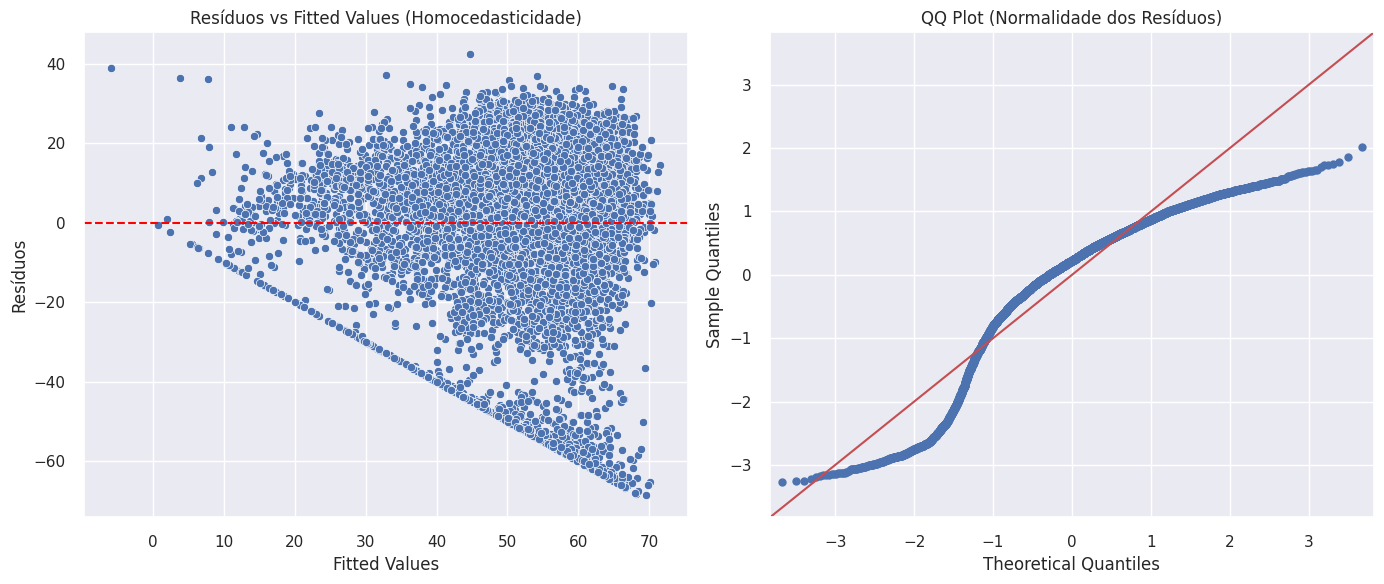

Teste de Shapiro-Wilk: Estatística=0.8944, p-valor=0.0000e+00
Conclusão: Os resíduos NÃO seguem uma distribuição normal (p < 0.05).


In [ ]:
# Diagnóstico dos Resíduos
residuals = model_sm.resid
fitted = model_sm.fittedvalues

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Resíduos vs Valores Ajustados (Homocedasticidade)
sns.scatterplot(x=fitted, y=residuals, ax=ax[0])
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title('Resíduos vs Fitted Values (Homocedasticidade)')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Resíduos')

# Gráfico 2: QQ Plot (Normalidade)
sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
ax[1].set_title('QQ Plot (Normalidade dos Resíduos)')

plt.tight_layout()
plt.show()

# Teste de Normalidade (Shapiro-Wilk)
from scipy import stats
# Usamos uma amostra se o dataset for muito grande para o Shapiro
shapiro_test = stats.shapiro(residuals.sample(min(5000, len(residuals))))
print(f"Teste de Shapiro-Wilk: Estatística={shapiro_test[0]:.4f}, p-valor={shapiro_test[1]:.4e}")
if shapiro_test[1] < 0.05:
    print("Conclusão: Os resíduos NÃO seguem uma distribuição normal (p < 0.05).")
else:
    print("Conclusão: Os resíduos seguem uma distribuição normal.")

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_val)

print("MAE:", mean_absolute_error(y_val, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, pred)))
print("R²:", r2_score(y_val, pred))

MAE: 15.910593524495095
RMSE: 21.4447505776136
R²: 0.22648091922959257


In [ ]:
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

reg_poly = LinearRegression()
reg_poly.fit(X_train_poly, y_train)

pred_poly = reg_poly.predict(X_val_poly)

print("RMSE Polinomial:", np.sqrt(mean_squared_error(y_val, pred_poly)))

RMSE Polinomial: 21.7807188290281


In [ ]:
nb = GaussianNB()
nb.fit(X_train_c, y_train_c)

pred_nb = nb.predict(X_val_c)

print("Acurácia:", accuracy_score(y_val_c, pred_nb))
print("F1:", f1_score(y_val_c, pred_nb))

Acurácia: 0.6855575868372943
F1: 0.18867924528301888


In [ ]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_c, y_train_c)

pred_log = logreg.predict(X_val_c)

print("Acurácia:", accuracy_score(y_val_c, pred_log))
print("F1:", f1_score(y_val_c, pred_log))
print("AUC:", roc_auc_score(y_val_c, logreg.predict_proba(X_val_c)[:,1]))

Acurácia: 0.7404021937842779
F1: 0.2864321608040201
AUC: 0.7490089940039973


In [ ]:
params = {
    "C": [0.1, 1, 3, 10],
    "solver": ["lbfgs"],
    "penalty": ["l2"]
}

grid = GridSearchCV(LogisticRegression(max_iter=500), params, scoring="f1", cv=5)
grid.fit(X_train_c, y_train_c)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor F1:", grid.best_score_)

Melhores parâmetros: {'C': 3, 'penalty': 'l2', 'solver': 'lbfgs'}
Melhor F1: 0.24327146707618677


In [ ]:
best = grid.best_estimator_
pred_best = best.predict(X_val_c)

print("Acurácia:", accuracy_score(y_val_c, pred_best))
print("F1:", f1_score(y_val_c, pred_best))
print("AUC:", roc_auc_score(y_val_c, best.predict_proba(X_val_c)[:,1]))

Acurácia: 0.7404021937842779
F1: 0.2864321608040201
AUC: 0.7490048301132578


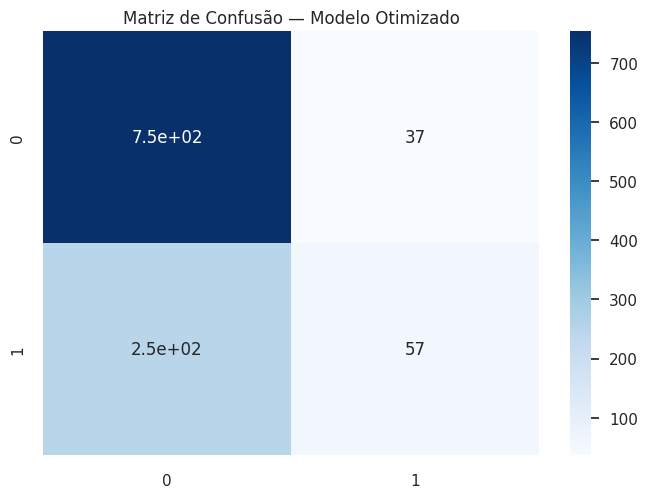

In [ ]:
sns.heatmap(confusion_matrix(y_val_c, pred_best), annot=True, cmap="Blues")
plt.title("Matriz de Confusão — Modelo Otimizado")
plt.show()

In [ ]:
X_vif = df[['artist_popularity', 'artist_followers', 'track_duration_ms',
            'track_number', 'album_total_tracks', 'explicit', 'album_year']]

# Adicionar a constante para o cálculo do VIF
X_vif_with_const = sm.add_constant(X_vif)

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_with_const.values, i)
                   for i in range(X_vif_with_const.shape[1])]

print("VIF dos preditores:")
print(vif_data.sort_values(by="VIF", ascending=False))

VIF dos preditores:
              feature           VIF
0               const  56349.214379
1   artist_popularity      1.818543
2    artist_followers      1.802977
5  album_total_tracks      1.501322
4        track_number      1.415271
7          album_year      1.226287
3   track_duration_ms      1.143647
6            explicit      1.059752


In [ ]:
# 1. Encontrar os valores de popularidade que só aparecem uma vez
popularidade_counts = df['track_popularity'].value_counts()
valores_para_remover = popularidade_counts[popularidade_counts == 1].index.tolist()

print(f"Número de valores únicos de popularidade que aparecem apenas 1 vez: {len(valores_para_remover)}")

# 2. Filtrar o DataFrame, removendo as linhas problemáticas
df_corrigido = df[~df['track_popularity'].isin(valores_para_remover)].copy()

print(f"Tamanho original do DF: {len(df)}")
print(f"Tamanho do DF após correção: {len(df_corrigido)}")

# O PyCaret setup agora deve usar este novo DataFrame
df = df_corrigido

Número de valores únicos de popularidade que aparecem apenas 1 vez: 3
Tamanho original do DF: 8573
Tamanho do DF após correção: 8570


# **Relatório de Projeto: Modelagem Preditiva com PyCaret**
**Introdução e Definição do Problema**
Este projeto utiliza a biblioteca pycaret para automatizar e otimizar dois problemas de Machine Learning em um conjunto de dados de faixas musicais:

**Regressão:** Prever a popularidade de uma faixa (track_popularity), que é uma variável contínua.

**Classificação:** Classificar se uma faixa é um "sucesso" (hit), que é uma variável binária (0 ou 1).

**Regressão - Previsão de Popularidade (track_popularity)**

**Configuração (setup)**

A função setup configurou o ambiente para Regressão com os seguintes passos:

**Variável-Alvo:** track_popularity.

**Normalização:** normalize = True para padronizar os dados, ajudando modelos baseados em distância (como Regressão Linear) a performar melhor.

**Validação Cruzada:** fold_strategy='kfold' para avaliação robusta.

**Comparação de Modelos**

A função compare_models() executou e avaliou diversos algoritmos de Regressão. A tabela abaixo lista os resultados iniciais dos principais modelos, ordenados pela métrica de desempenho (R²)

**Otimização e Avaliação Final**

O modelo de melhor desempenho foi otimizado usando tune_model(optimize='R2').

**Otimização:** A busca por hiperparâmetros (tuning) foi realizada para maximizar o R² do modelo.

**Avaliação Gráfica (evaluate_model):** A função evaluate_model(tuned_reg_model) gera gráficos de diagnóstico cruciais para a análise, incluindo o Gráfico de Resíduos e o Gráfico de Erro de Previsão.

In [ ]:
s_reg = setup(data = df,
              target = 'track_popularity',
              numeric_features = ['artist_followers', 'track_duration_ms', 'track_number',
                                  'album_total_tracks', 'album_year', 'explicit', 'artist_popularity'],
              ignore_features = ['track_id', 'album_id', 'album_release_date', 'track_name',
                                 'artist_name', 'album_name', 'album_genres', 'album_type'],
              session_id = 42,
              normalize = True,
              n_jobs = -1,
              fold_strategy='kfold',
              verbose = False)

print("\nComparando modelos de Regressão...")

# CÉLULA 3: COMPARAR MODELOS
best_reg_model = compare_models()

# Puxa o resultado da última operação (compare_models) como um DataFrame
tabela_comparacao = pull()
print("Tabela de Comparação de Modelos (Forçada):")
print(tabela_comparacao)


# CÉLULA 4: TUNING E AVALIAÇÃO
# Agora que o best_reg_model está definido, podemos continuar
tuned_reg_model = tune_model(best_reg_model, optimize='R2')

# Avaliar o Modelo Otimizado (Gera os gráficos de diagnóstico para seu relatório)
evaluate_model(tuned_reg_model)


Comparando modelos de Regressão...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,10.4783,244.2353,15.6164,0.5718,0.9791,1.0537,2.2590
lightgbm,Light Gradient Boosting Machine,10.8923,250.2699,15.8108,0.5610,0.9968,1.1141,0.4340
et,Extra Trees Regressor,10.4421,252.2370,15.8673,0.5578,0.9710,1.0267,0.9040
gbr,Gradient Boosting Regressor,11.4062,260.9319,16.1472,0.5423,1.0173,1.1863,0.5130
xgboost,Extreme Gradient Boosting,11.2450,264.7672,16.2626,0.5356,0.9873,1.0871,0.1740
ridge,Ridge Regression,12.3651,288.3082,16.9722,0.4944,1.0401,1.2477,0.1100
lar,Least Angle Regression,12.3652,288.3074,16.9722,0.4944,1.0401,1.2477,0.1090
br,Bayesian Ridge,12.3633,288.3176,16.9725,0.4944,1.0403,1.2480,0.0880
lr,Linear Regression,12.3652,288.3074,16.9722,0.4944,1.0401,1.2477,0.0630
llar,Lasso Least Angle Regression,12.5367,292.3320,17.0902,0.4875,1.0470,1.2398,0.0920


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Tabela de Comparação de Modelos (Forçada):
                                    Model      MAE       MSE     RMSE      R2  \
rf                Random Forest Regressor  10.4783  244.2353  15.6164  0.5718   
lightgbm  Light Gradient Boosting Machine  10.8923  250.2699  15.8108  0.5610   
et                  Extra Trees Regressor  10.4421  252.2370  15.8673  0.5578   
gbr           Gradient Boosting Regressor  11.4062  260.9319  16.1472  0.5423   
xgboost         Extreme Gradient Boosting  11.2450  264.7672  16.2626  0.5356   
ridge                    Ridge Regression  12.3651  288.3082  16.9722  0.4944   
lar                Least Angle Regression  12.3652  288.3074  16.9722  0.4944   
br                         Bayesian Ridge  12.3633  288.3176  16.9725  0.4944   
lr                      Linear Regression  12.3652  288.3074  16.9722  0.4944   
llar         Lasso Least Angle Regression  12.5367  292.3320  17.0902  0.4875   
lasso                    Lasso Regression  12.5367  292.3323  17.0

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.7048,237.3047,15.4047,0.5539,0.9632,0.9942
1,10.9531,249.1551,15.7846,0.5393,0.9264,1.3368
2,10.7790,252.3644,15.8860,0.5641,1.0384,0.9225
3,11.0748,268.2891,16.3795,0.5666,1.0914,1.5853
4,10.8469,240.5239,15.5088,0.5584,0.9421,0.9593
5,11.0185,261.4540,16.1695,0.5579,1.0651,1.3444
6,10.3496,217.4458,14.7460,0.5842,0.8950,1.0482
7,11.1459,248.8866,15.7761,0.5834,1.0632,1.1922
8,11.4809,270.4780,16.4462,0.5394,1.0271,0.9561


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# **Classificação - Previsão de Sucesso (hit)**
**Configuração e Tratamento de Desbalanceamento**

A configuração para Classificação seguiu uma abordagem diferente para lidar com a natureza binária do alvo:

**Variável-Alvo:** hit (0 ou 1).

**Tratamento de Desbalanceamento:** fix_imbalance=True foi aplicado. Isso é essencial, pois em datasets reais, o número de faixas 'hit' (1) pode ser muito menor que o de faixas 'não-hit' (0).

**Comparação de Modelos e Seleção**

A comparação focou em modelos de referência (lr, nb) e modelos de alto desempenho (rf, xgboost), otimizando o processo pela métrica AUC (Area Under the Curve).

**Otimização e Visualização**

O modelo de melhor desempenho (best_clf) foi otimizado usando tune_model(optimize='AUC') para maximizar sua capacidade de discriminar entre as classes "hit" e "não-hit".

Comparando modelos de Classificação:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4720
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1570
lr,Logistic Regression,0.9942,0.9995,0.9922,0.9872,0.9896,0.9856,0.9856,0.6750
nb,Naive Bayes,0.5637,0.6292,0.6337,0.3453,0.4467,0.1358,0.1531,0.1450


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


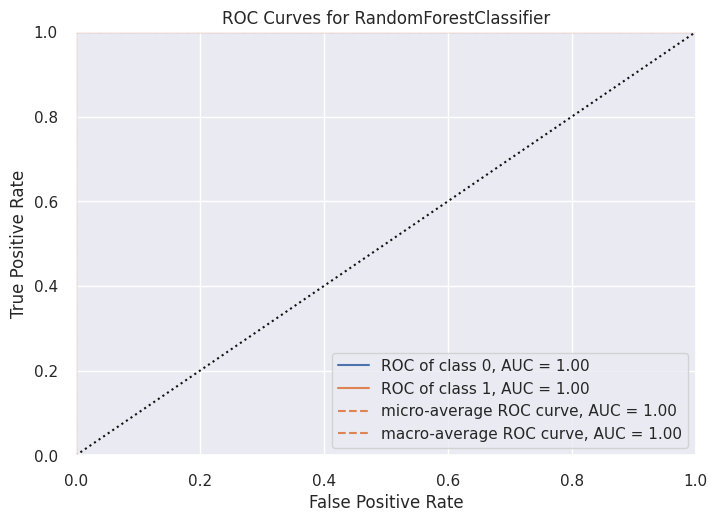

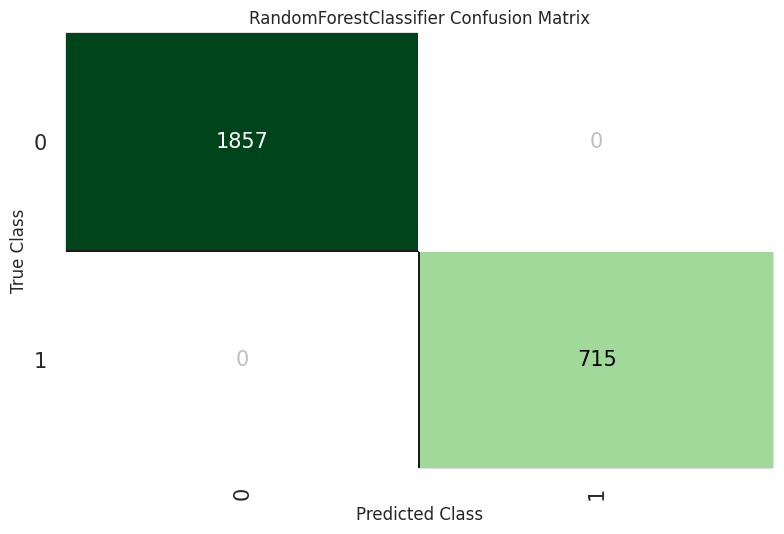

In [ ]:
s_clf = setup(data = df, target = 'hit',
              numeric_features = ['artist_followers', 'track_duration_ms', 'track_number', 'album_total_tracks', 'album_year', 'track_popularity'],
              ignore_features = ['track_id', 'album_id', 'album_release_date'],
              session_id = 42,
              fix_imbalance=True, # Trata o desbalanceamento das classes
              verbose = False)

# Comparar modelos (Incluindo Naive Bayes e Regressão Logística exigidos)
# O PyCaret roda vários, mas vamos focar nos pedidos + melhores
print("Comparando modelos de Classificação:")
best_clf = compare_models(include=['lr', 'nb', 'rf', 'xgboost'], sort='AUC')

# Otimização
tuned_clf = tune_model(best_clf, optimize='AUC')

# Avaliação Gráfica (AUC e Matriz de Confusão)
plot_model(tuned_clf, plot='auc')
plot_model(tuned_clf, plot='confusion_matrix')

# **Licença**

CC0: Public Domain

https://creativecommons.org/publicdomain/zero/1.0/